In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
import pandas as pd
file_path = "cleaned_coin_Bitcoin.csv" 
df = pd.read_csv(file_path)

In [3]:
# 1. Normalize the data for LSTM (scaling it between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values)

In [4]:
# 2. Function to create dataset for LSTM with a given time_step
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # Features (previous 'time_step' values)
        y.append(data[i + time_step, 0])  # Target (next value, i.e., the future close price)
    return np.array(X), np.array(y)


In [5]:
# 3. Create dataset using 60 time steps (past 60 days to predict the next day's closing price)
time_step = 60
X, y = create_dataset(scaled_data, time_step)


In [6]:
# 4. Reshape X to be 3D (samples, time_steps, features) as required by LSTM
X = X.reshape(X.shape[0], X.shape[1], 1)  # Add 1 for the feature dimension


In [7]:
# 5. Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(2184, 60, 1), y_train=(2184,)
Testing data shape: X_test=(547, 60, 1), y_test=(547,)


In [8]:
# 6. Build the LSTM model
model = Sequential()

In [9]:
# Add LSTM layers
from tensorflow.keras.layers import Input

model.add(Input(shape=(X_train.shape[1], 1))) 
# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True))  # First LSTM layer
model.add(Dropout(0.2))  # Dropout for regularization for no overfitting
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer (final one)
model.add(Dropout(0.2))  # Dropout for regularization

# Output layer
model.add(Dense(units=1))  # Predict the next 'Close' value



In [10]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.8251e-04 - val_loss: 0.0033
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - loss: 1.4083e-04 - val_loss: 0.0029
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 1.2644e-04 - val_loss: 0.0036
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.4153e-04 - val_loss: 0.0047
Epoch 6/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 1.0740e-04 - val_loss: 0.0062
Epoch 7/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 9.9092e-05 - val_loss: 0.0022
Epoch 8/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 1.1949e-04 - val_loss: 0.0070
Epoch 9/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 1.0594e-04 - val_loss: 0.0020
Epoch 10/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 1.0272e-04 - val_loss: 0.0046


In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.0417068478140178
Mean Squared Error (MSE): 0.004552979718934608
Root Mean Squared Error (RMSE): 0.06747577134745929
R-squared (R²): 0.9415660034726119


In [14]:
# Save the model in the native Keras format
model.save('bitcoin_lstm_model.keras')

print("Model saved in the native Keras format")


Model saved in the native Keras format


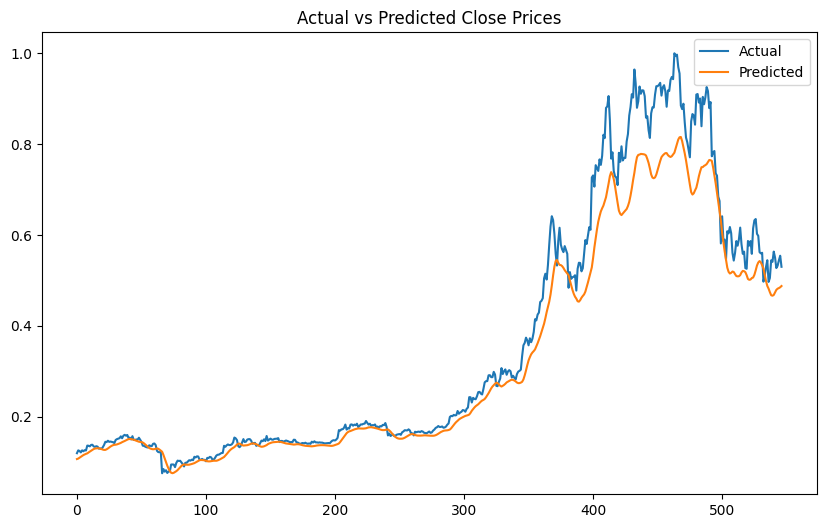

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.show()